## Data preparation
- The purpose is to practice using pandas to preprare data into a suitable form for further analysis

### Import libraries

In [1]:
import pandas as pd

### Download data

In [2]:
# !curl -o './data/movie-data.zip' 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
# !unzip './data/movie-data.zip' -d './data'

### Read data

In [3]:
movies = pd.read_csv('./data/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Check duplicate rows

In [5]:
movies[movies.duplicated(subset=['movieId'])]

,movieId,title,genres


In [6]:
dup_movie_ids = movies[movies.duplicated(subset=['title'], keep=False)].reset_index().movieId

movies[movies.duplicated(subset=['title'], keep=False)]

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


In [7]:
ratings[ratings.duplicated(subset=['userId', 'movieId'])]

,userId,movieId,rating,timestamp


In [8]:
dup_movie_ratings = (
    ratings[ratings.movieId.isin(dup_movie_ids)]
    .merge(movies[['movieId', 'title']], on='movieId')
    .groupby(['title', 'movieId'], as_index=False)
    .size()
)
dup_movie_ratings

,title,movieId,size
0,Confessions of a Dangerous Mind (2002),6003,15
1,Confessions of a Dangerous Mind (2002),144606,1
2,Emma (1996),838,30
3,Emma (1996),26958,1
4,Eros (2004),32600,1
5,Eros (2004),147002,1
6,Saturn 3 (1980),2851,4
7,Saturn 3 (1980),168358,1
8,War of the Worlds (2005),34048,50
9,War of the Worlds (2005),64997,2


> **Observation**
> - Movies dataset consist of some movies that have same title with others but have additional genres
> - On the other hand, movie ratings dataframe have no duplicate records
> - Some users have rated movies that have duplicate records

### Check NAs

In [9]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [10]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

> **Observation**
> - There exist no missing values in both movies dataframe and ratings dataframe

### Preparation
- Split genres from each movie into multiple binary columns of genres. Hint: Use Split-Expand. Then Melt/Pivot (column ordering doesn’t matter)
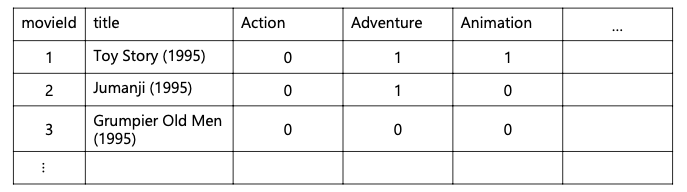

In [11]:
movies_genre = (
    movies.merge(
        movies.genres.str.split(pat='|', expand=True),
        how='inner',
        left_index=True,
        right_index=True
    )
    .drop(columns=['genres'])
    .melt(
        id_vars=['movieId', 'title'],
        value_vars=range(0,10),
        var_name='i',
        value_name='genre'
    )
    .pivot_table(
        index=['movieId', 'title'],
        columns='genre',
        values='i',
        aggfunc='nunique',
        fill_value=0
    )
    .rename_axis(None, axis=1)
    .reset_index()
    .drop(columns = ['(no genres listed)'])
)

movies_genre.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Extract year from title into new column. Hint: Use String-Extract (column ordering doesn’t matter)
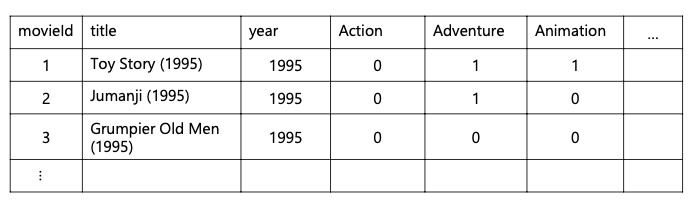

In [12]:
movies_genre['year'] = movies_genre.title.str.extract("\((\d{4}).*\)")
movies_genre.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995


In [13]:
movies_genre.isna().sum()

movieId         0
title           0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
IMAX            0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
year           12
dtype: int64

In [14]:
movies_genre[movies_genre.year.isna()]

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
6059,40697,Babylon 5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
9031,140956,Ready Player One,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,NaN
9091,143410,Hyena Road,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9179,149334,Nocturnal Animals,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,NaN
9259,156605,Paterson,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9367,162414,Moonlight,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
9448,167570,The OA,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9514,171495,Cosmos,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
9515,171631,Maria Bamford: Old Baby,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


> **Observation**
> - There are some movies which year is unknown and this is because the movie title did not match our serach pattern (did not contain year)

- Merge movie into rating. Use movieId as a key (column ordering doesn’t matter)
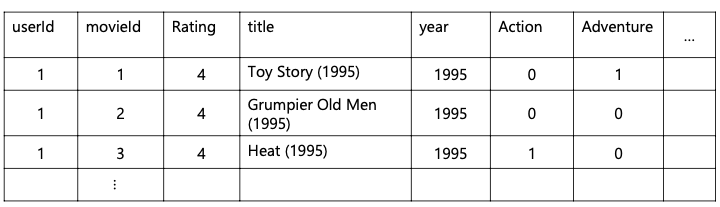

In [15]:
movie_rating = (
    ratings.merge(movies_genre, on=['movieId']) # default inner join
    .drop(columns=['timestamp'])
    .sort_values(['userId', 'movieId'])
)
movie_rating.head()

,userId,movieId,rating,title,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,1,4.0,Toy Story (1995),0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1995
215,1,3,4.0,Grumpier Old Men (1995),0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
267,1,6,4.0,Heat (1995),1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1995
369,1,47,5.0,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1995
572,1,50,5.0,"Usual Suspects, The (1995)",0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1995


In [16]:
movie_rating.isna().sum()

userId          0
movieId         0
rating          0
title           0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
IMAX            0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
year           17
dtype: int64

In [17]:
movie_rating[movie_rating.year.isna()].groupby('movieId').size()

movieId
40697     2
140956    4
143410    1
147250    1
149334    1
156605    1
162414    1
167570    1
171495    2
171631    1
171891    1
176601    1
dtype: int64

> **Observation**
> - After joining, we can see that no. of rows that have missing (year) value increased which is because the movies with missing year have been rated multiple times by different users

- Obtain top 10 most reviewed movies of each year

In [18]:
# count no. of rating for each movie
rating_cnt = (
    movie_rating
    .groupby(['year', 'movieId', 'title'], as_index=False)
    .size()
    .reset_index(drop=True)
)

In [19]:
# rank movies of each year by rating count
rating_cnt['rank'] = (
    rating_cnt
    .groupby('year', as_index = False)['size']
    .rank('min', ascending=False)
)

In [20]:
# get top 10 most reviewed movies of each year
top_10_by_year = (
    rating_cnt[rating_cnt['rank'] <= 10]
    .rename(columns = {'size': 'reviews'})
)

top_10_by_year

,year,movieId,title,reviews,rank
0,1902,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ...",5,1.0
1,1903,49389,The Great Train Robbery (1903),2,1.0
2,1908,140541,The Electric Hotel (1908),1,1.0
3,1915,7065,"Birth of a Nation, The (1915)",1,1.0
4,1916,7243,Intolerance: Love's Struggle Throughout the Ag...,1,2.0
...,...,...,...,...,...
9695,2018,187541,Incredibles 2 (2018),4,5.0
9696,2018,187593,Deadpool 2 (2018),12,2.0
9697,2018,187595,Solo: A Star Wars Story (2018),5,3.0
9700,2018,188301,Ant-Man and the Wasp (2018),3,8.0


- Obtain top 5 movies of each user

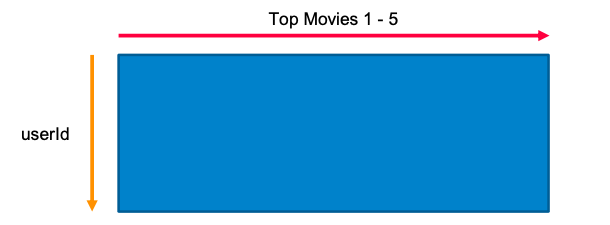

In [21]:
# subset columns
movie_user_rating = movie_rating[['userId', 'title', 'rating']]

# temporarily separate title column which is not used for computation
movie_user_rating = (
    movie_user_rating
    .set_index('title')
    .sort_values(['userId', 'rating'])
)

In [22]:
# rank movies reviewed by user using rating
movie_user_rating['rank'] = (
    movie_user_rating
    .groupby('userId')['rating']
    .rank('first', ascending=False) # no ties in rank
).astype('int')

# get 5 top-rated movies for each user 
movie_user_rating = movie_user_rating[movie_user_rating['rank'] <= 5]

In [23]:
# create rank labels
movie_user_rating['top'] = 'top movie ' + movie_user_rating['rank'].astype('str')

# drop unused columns
movie_user_rating_reduced = movie_user_rating.drop(columns=['rating', 'rank']).reset_index()

In [24]:
# prepare data into wanted format
top5_user_movie = (
    movie_user_rating_reduced
    .pivot(index=['userId'], columns=['top'], values='title')
    .rename_axis('movies', axis=1)
)
top5_user_movie

movies,top movie 1,top movie 2,top movie 3,top movie 4,top movie 5
userId,,,,,
1,Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)",Bottle Rocket (1996),Rob Roy (1995),Canadian Bacon (1995)
2,Step Brothers (2008),Inside Job (2010),Warrior (2011),"Wolf of Wall Street, The (2013)",Mad Max: Fury Road (2015)
3,Escape from L.A. (1996),Saturn 3 (1980),"Road Warrior, The (Mad Max 2) (1981)",The Lair of the White Worm (1988),Hangar 18 (1980)
4,Flirting With Disaster (1996),Crumb (1994),Living in Oblivion (1995),Before Sunrise (1995),Eat Drink Man Woman (Yin shi nan nu) (1994)
5,"Postman, The (Postino, Il) (1994)",Heavenly Creatures (1994),Once Were Warriors (1994),Pulp Fiction (1994),In the Name of the Father (1993)
...,...,...,...,...,...
606,Eat Drink Man Woman (Yin shi nan nu) (1994),Pulp Fiction (1994),Schindler's List (1993),Blade Runner (1982),"Philadelphia Story, The (1940)"
607,Braveheart (1995),Apollo 13 (1995),"Prophecy, The (1995)","Shawshank Redemption, The (1994)",Wes Craven's New Nightmare (Nightmare on Elm S...
608,Pulp Fiction (1994),"Godfather, The (1972)",Gattaca (1997),Dark City (1998),Rounders (1998)


- Create a user profile matrix which consists of: 
    - User ID
    - Number of times that user rate the movie
    - Average rating that user gives
    - Median of the year of movies that user rated

In [25]:
# select useful columns
subset_profile_mat = movie_rating[['movieId', 'year', 'userId', 'rating']]

# create profile matrix
profile_mat = (
    subset_profile_mat
    .groupby('userId', as_index=False)[['movieId', 'year', 'rating']]
    .agg({
        'movieId': 'nunique',
        'rating': 'mean',
        'year': lambda x : x.dropna().astype('int').median()
    })
    .rename(columns={
        'movieId': 'rating count',
        'rating': 'average rating',
        'year': 'movie year median'
    })
)

profile_mat

,userId,rating count,average rating,movie year median
0,1,232,4.366379,1990.0
1,2,29,3.948276,2010.0
2,3,39,2.435897,1982.0
3,4,216,3.555556,1994.0
4,5,44,3.636364,1994.0
...,...,...,...,...
605,606,1115,3.657399,1994.0
606,607,187,3.786096,1992.0
607,608,831,3.134176,1997.0
608,609,37,3.270270,1995.0
